In [270]:
import os, sys, math, importlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers as tfl
import tensorflow_io as tfio
import tensorflow_datasets as tfds

#import skimage.transform as trans
#import cv_image_proc

#tf.config.run_functions_eagerly(True) # this is needed for debugging!!!
#tf.data.experimental.enable_debug_mode() # eager execution of tf.data functions

print(f"Function exec eagerly: {tf.executing_eagerly()}")
print(tf.config.list_physical_devices('GPU'))
print(f"Tensorflow version: {tf.__version__} tf io: {tfio.__version__}")


Function exec eagerly: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.10.1 tf io: 0.26.0


In [381]:
import common
importlib.reload(common)
from common import *
from enum import IntEnum

# this prepares the main data set by parsing files, could take long
#NAS_dir = "Y:/Schwind/Titan/FeldTest_SW1.2/original/"
base_dir = "C:/SchwindResource/FieldTest/"
csv_set = tf.data.Dataset.list_files(base_dir + "Vid*.csv")
origSize = (800,800)
croppedSize, scaleFactor = (512,512), 2
cropFactor = float(croppedSize[0]) / origSize[0] # central crop factor to reduce image size.. 
ofsX, ofsY = float(origSize[0] - croppedSize[0])/scaleFactor, float(origSize[1] - croppedSize[1])/scaleFactor
imageShape = (256,256,1) # this is basically croppedSize/scaleFactor

#vidFile = NAS_dir + "20210519/Patient1/2021-05-14__08-46-05__13388512_SUNJO_Graciela_OD.Cam1VID._TiCam1_210514_084605.avi"
#zz = tfio.IODataset.from_ffmpeg(", #               "v:0")
#vid = tfio.experimental.ffmpeg.decode_video(vidFile, "0")

class CSV(IntEnum):
    FName = 0  
    FrameNo = 1 
    EyeCode = 2
    PupilQ = 3
    PupilX = 4
    PupilY = 5
    PupilR = 6

def loadByFrameNo(*csv):
    frameS = tf.strings.as_string(csv[CSV.FrameNo], width=6, fill='0')
    name = csv[CSV.FName] + frameS + '.png'
    bytes = tf.io.read_file(name)
    image = tf.io.decode_png(bytes)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image =  tf.image.central_crop(image, cropFactor)
    Q, X, Y, R = csv[CSV.PupilQ:]
    #Q = 0.0 if Q < 30 else 1.0 # map to 0-1 range
    img = tf.image.resize(image, imageShape[:-1])
    img -= tf.math.reduce_mean(img, keepdims=True)
    img /= (tf.math.reduce_std(img, keepdims=True) + 1e-6)
    #img = img - tf.reduce_mean(img)
    #name += "_Q" + tf.strings.as_string(Q)
    X, Y, R = (X - ofsX)/croppedSize[0], (Y - ofsY)/croppedSize[1], R / croppedSize[0]
    #if Q == 0.0:
    #  X, Y, R = 0.0,0.0,0.0
    # yields image, quality, X, Y, Radius. Quality might be 0 or 1: either image is there or not ?..
    return (img, tf.convert_to_tensor([X, Y, R], dtype=tf.float32)) #, name) 

   # TODO:: use only  very good examles where quality is  close to 100
# FrameNo ; EyeCode ; PupilQ ; PupilX  ; PupilY  ; PupilR ; CycloQ ; Angle  ; PSTValue ; RadStdDev ; AvgGradient ; MaxHoughCenter ; 
csvFields = [str(), int(), str(), int(), float(), float(), float()] #, float(), float(), float(), float(), float(), float()]
def singleCSV(fname):
    # choose only those frames which are OK (eyecode is OK)
    framesDir = tf.strings.regex_replace(fname, '_sim[0-9]+\.csv', '_Frames\\\\scene;')
    # we do not filter over OK field but just skip 3 first records => these are header
    #filter(lambda x: tf.strings.regex_full_match(x, "\d+\s+;\s*OK\s.*"))
    return tf.data.TextLineDataset(fname).skip(3). \
        map(lambda x: tf.io.decode_csv(tf.strings.join([framesDir,x]), csvFields, field_delim=';', select_cols=[0,1,2,3,4,5,6])). \
        filter(lambda *csv: csv[CSV.PupilQ] >= 90 and csv[CSV.FrameNo] > 50 and csv[CSV.FrameNo] % 13 == 0) 
        # skip first 20 frames used for white ring detection, and choose every 7th frame



b'C:\\SchwindResource\\FieldTest\\Vid37_2021-07-15__13-47-34__Patient8_Frames\\scene' - 3107; q: 93
b'C:\\SchwindResource\\FieldTest\\Vid42_2021-08-02__18-30-14__Patient3_Frames\\scene' - 2691; q: 90
b'C:\\SchwindResource\\FieldTest\\Vid54_2021-08-09__16-35-16__Patient5_Frames\\scene' - 2600; q: 93
b'C:\\SchwindResource\\FieldTest\\Vid28_2021-07-22__13-30-50__Patient8_Frames\\scene' - 2626; q: 90
b'C:\\SchwindResource\\FieldTest\\Vid21_2021-07-22__11-33-55__Patient1_Frames\\scene' - 3614; q: 91
b'C:\\SchwindResource\\FieldTest\\Vid25_2021-07-22__12-25-35__Patient5_Frames\\scene' - 3224; q: 94
b'C:\\SchwindResource\\FieldTest\\Vid20_Patient9_Frames\\scene' - 5278; q: 100
b'C:\\SchwindResource\\FieldTest\\Vid59_2021-08-16__12-11-00__Patient1_Frames\\scene' - 6578; q: 93
b'C:\\SchwindResource\\FieldTest\\Vid37_2021-07-15__13-47-34__Patient8_Frames\\scene' - 3146; q: 96
b'C:\\SchwindResource\\FieldTest\\Vid42_2021-08-02__18-30-14__Patient3_Frames\\scene' - 2704; q: 91
0.477070332 0.5010937

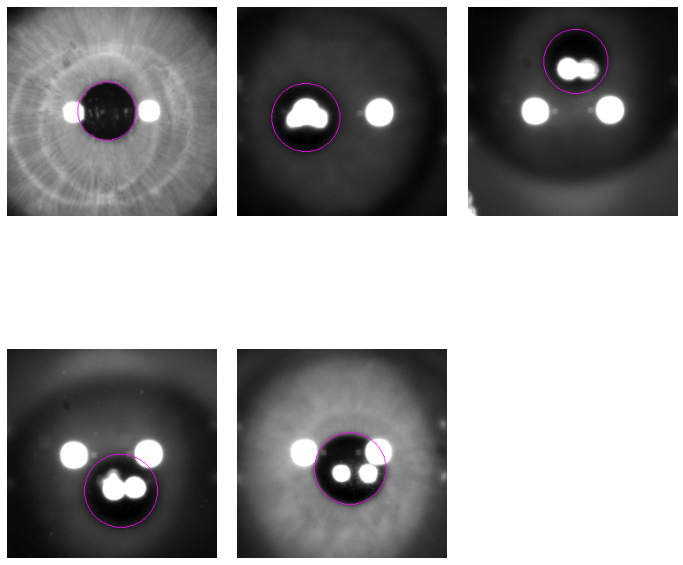

In [382]:
fullDS = csv_set.interleave(singleCSV)
#for A in fullDS.take(10):   
#     print(A)
for (name,frameNo,OK,q,x,y,R) in fullDS.take(10):   
     print(f"{name.numpy()} - {frameNo.numpy()}; q: {q}")

fullDS = fullDS.map(loadByFrameNo)
displayDS(fullDS, 5, lambda img,bbox : drawCircleImg(img, bbox))

In [ ]:
import NN_Blocks
importlib.reload(NN_Blocks)
from NN_Blocks import *
from enum import IntEnum

TEST_SZ = 1000
VALID_SZ = 1000
TRAIN_LENGTH = 11111 #info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 10000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# TODO try tf.keras.utils.image_dataset_from_directory
# shuffle csv data before loading images..
# better shuffle the filenames directly before loading image data
# shuffle().repeat(): "1 3 2, 1 3 2, 1 3 2" or "3 1 2, 3 1 2, 3 1 2"
fullDS = csv_set.interleave(singleCSV).shuffle(BUFFER_SIZE).map(loadByFrameNo)

# compute radiuses, X and Y
#sum,num = fullDS.reduce((tf.zeros(3, tf.float32), 0.0), lambda s,item : (s[0] + item[1], s[1] + 1))
#print("result: ",sum,num,sum/num)

train_batches = (fullDS
     .cache()
     .batch(BATCH_SIZE)
     .repeat()
     #.map(Augment())
     .prefetch(buffer_size=tf.data.AUTOTUNE))

#tfds.benchmark(train_batches, batch_size=BATCH_SIZE)
  
testS = fullDS.take(TEST_SZ) 
validS = fullDS.skip(TEST_SZ).take(VALID_SZ)   
trainS = fullDS.skip(TEST_SZ + VALID_SZ)  

inputs = tfl.Input(shape=imageShape)
useBN=True
#vgg_block(X, num_filters, num_convs, kernel_size=3, useBN=False):
#conv_stride_block(X, num_filters, useBN=False):
#conv_dilate_block(X, num_filters, dilate=1, useBN=False):

numFlts = 32
X = conv_block(inputs, numFlts, useBN=useBN)
X = vgg_block(X, numFlts, num_convs=3, kernel_size=3, useBN=useBN)
X = vgg_block(X, numFlts*2, num_convs=3, kernel_size=3, useBN=useBN)
X = vgg_block(X, numFlts*4, num_convs=3, kernel_size=3, useBN=useBN)
X = vgg_block(X, numFlts*8, num_convs=3, kernel_size=3, useBN=useBN)
#X = vgg_block(X, numFlts*8, num_convs=3, kernel_size=3, useBN=useBN)
#X = conv_block(X, numFlts, useBN=useBN)
#X = conv_stride_block(X, numFlts*2, useBN=useBN)
#X = conv_block(X, numFlts*2, useBN=useBN)
#X = conv_stride_block(X, numFlts*4, useBN=useBN)
#X = conv_dilate_block(X, numFlts*4, dilate=4, useBN=useBN)
#X = conv_stride_block(X, numFlts*8, useBN=useBN)
#X = conv_block(X, numFlts*8, useBN=useBN)
#X = conv_dilate_block(X, numFlts*4, dilate=16, useBN=useBN)

#X = vgg_block(inputs, 32, num_convs=3, kernel_size=5, useBN=useBN)
#X = vgg_block(X, 64, num_convs=3, kernel_size=3, useBN=useBN)
#X = vgg_block(X, 128, num_convs=2, kernel_size=3, if_batch_norm=if_batch_norm)
#X = vgg_block(X, 256, num_convs=2, kernel_size=3, if_batch_norm=if_batch_norm)
X = tf.keras.layers.GlobalAveragePooling2D()(X)
flatX = tfl.Flatten()(X)
X = tfl.Dense(32,activation="relu",name="extra_dense1")(flatX)
X = tfl.Dense(32,activation="relu",name="extra_dense2")(X)
X = tfl.Dense(3,activation="sigmoid",name="final")(X) # to zero-one range

model = keras.Model(inputs=inputs, outputs=X)
model.compile(optimizer='adam', loss=CicleDIoU_CELoss(alpha=1.5), metrics=[CircleIoU_Metric(BATCH_SIZE)])
model.summary()


In [388]:
try:
  model.fit(train_batches, epochs=20, steps_per_epoch=300)
  #model_history = model.fit(train_batches, epochs=EPOCHS,
                         #  steps_per_epoch=STEPS_PER_EPOCH,
                         #  validation_steps=VALIDATION_STEPS,
                         #  validation_data=test_batches,
                         #  callbacks=[DisplayCallback()])
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
300/300 [==============================] - 445s 1s/step - loss: 0.1852 - circle_io_u__metric_10: 0.6740
Epoch 2/20
300/300 [==============================] - 433s 1s/step - loss: 0.1455 - circle_io_u__metric_10: 0.7079
Epoch 3/20
300/300 [==============================] - 453s 2s/step - loss: 0.1463 - circle_io_u__metric_10: 0.7075
Epoch 4/20
300/300 [==============================] - 456s 2s/step - loss: 0.1360 - circle_io_u__metric_10: 0.7203
Epoch 5/20
300/300 [==============================] - 454s 2s/step - loss: 0.1344 - circle_io_u__metric_10: 0.7158
Epoch 6/20
300/300 [==============================] - 454s 2s/step - loss: 0.1542 - circle_io_u__metric_10: 0.7040
Epoch 7/20
300/300 [==============================] - 456s 2s/step - loss: 0.1322 - circle_io_u__metric_10: 0.7261
Epoch 8/20
300/300 [==============================] - 455s 2s/step - loss: 0.1337 - circle_io_u__metric_10: 0.7087
Epoch 9/20
300/300 [==============================] - 456s 2s/step - loss: 0.127

1 0.481464863 0.469921887 0.234199226
1 0.491406262 0.42228514 0.156972662
1 0.834023476 0.651992202 0.148066401
1 0.851250052 0.414648414 0.131132811
1 0.42125 0.326308608 0.197167963
1 0.511640608 0.465996087 0.18166016
1 0.490722656 0.424453139 0.161738276
1 0.512207031 0.489531279 0.230136722
1 0.481992185 0.454355478 0.184980467
1 0.500390649 0.512031257 0.155039057


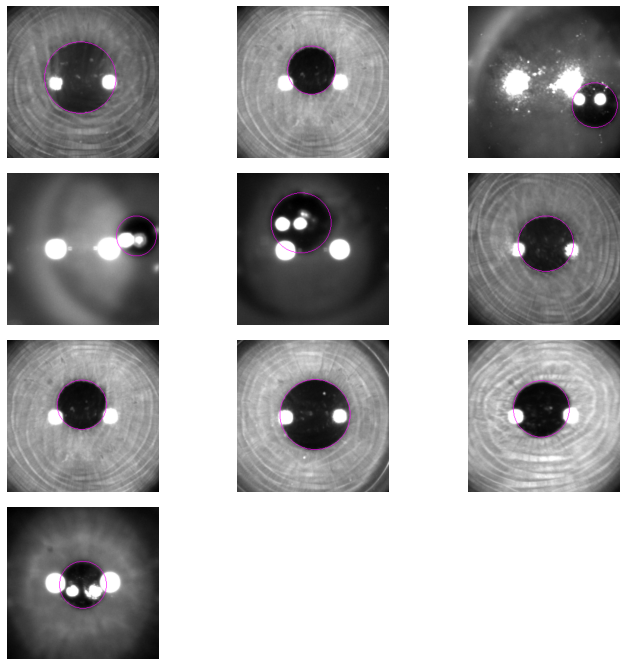

In [258]:
imageList = list(iter(fullDS.skip(10).take(10)))
displayDS(imageList, len(imageList), drawCircleImg)

#zz = zz.reshape(zz.shape[1:])
#yy = np.asarray(zz)
#print(yy.ndim)
#plt.imshow([aa,zz], cmap='gray')

#L = CicleDIoU_CELoss(1)
#y_true = tf.convert_to_tensor([[0, 0.5,0.5, 2]],dtype='float32')
#y_pred = tf.convert_to_tensor([[0.5, 0.5,0.5, 22]],dtype='float32')
#print(L(y_true,y_pred))



(10, 256, 256, 1)
1/1 [==============================] - 0s 44ms/step
0.46879193 0.48770568 0.47638965 0.19837089
0.46922094 0.4875753 0.47628805 0.20131323
0.47025245 0.48725203 0.47511196 0.21156602
0.4688389 0.48772123 0.47679093 0.19742797
0.46751612 0.4881549 0.47753873 0.1873095
0.4684782 0.487815 0.47665665 0.19565329
0.46929112 0.48755205 0.47624618 0.20187658
0.47196937 0.48731154 0.4745961 0.22515865
0.47167066 0.4872058 0.47439772 0.22362706
0.46871033 0.48776627 0.47690362 0.19630495


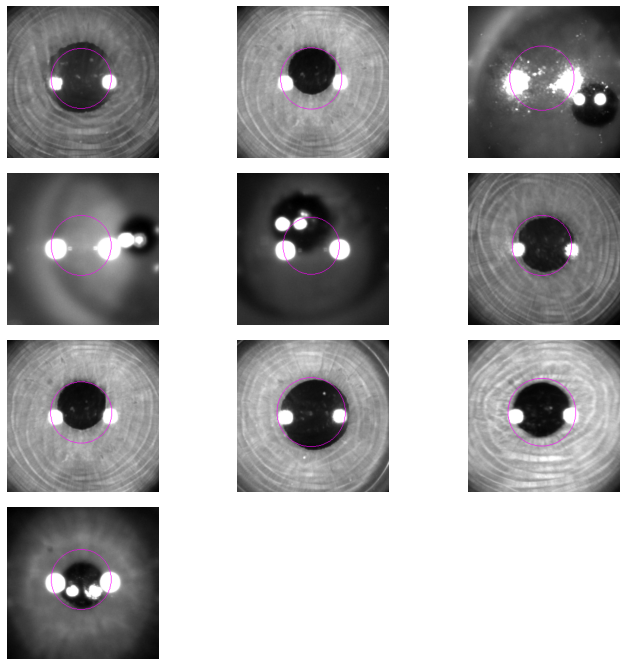

In [266]:
UU = tf.stack([img for img,pup in imageList], axis=0)
print(UU.shape)

inp = model.input                                           # input placeholder
outputs = [layer.output for i,layer in enumerate(model.layers) if i > 40]          # all layer outputs
Xmodel = keras.Model(inputs=model.input, outputs=outputs)
pup = model.predict(UU)

displayDS(zip(imageList, pup), len(imageList), lambda img,X: drawCircleImg(img[0],X))
